<a href="https://colab.research.google.com/github/doetools/deep_learning_tf/blob/main/deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

get started with basic tensorflow operations

In [ ]:
print(tf.__version__)

2.12.0


the eager mode and has to use gradient tape
https://www.tensorflow.org/guide/autodiff

In [ ]:
x = tf.Variable(3.0)
y = tf.Variable(4.0)

with tf.GradientTape() as tape:
  f = x*x*y + y +2

dy_dx = tape.gradient(f, x)
dy_dx.numpy()

24.0

the non-eager mode as decorated by tf.function, which will first convert the python function into a graph (DAG) and then solve it.

In [ ]:
import tensorflow as tf

x = tf.Variable(3.,name="x",trainable=True)
y = tf.Variable(4.,name="y",trainable=True)


@tf.function
def fn(x, y):
  f = x*x*y + y +2
  g = tf.gradients(f,x)
  tf.print(g)
  return g

g = fn(x, y)
print(g)
print(type(g))


[24]
[<tf.Tensor: shape=(), dtype=float32, numpy=24.0>]
<class 'list'>


some basic linear algbra


In [ ]:
a = tf.constant([[1,2],[3 ,4]])
b = tf.constant([[3,4], [5, 6]])


mul= a*b

# a
tf.transpose(a)
a@tf.transpose(b)
mul == tf.multiply(a,b)

tf.reduce_sum(a)

if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS** using the GPU


a linear regression example
p 236

In [57]:
import numpy as np
from sklearn.datasets import fetch_california_housing
import tensorflow as tf


housing = fetch_california_housing()

# m is row which is instance and n is column which is feature
m, n = housing.data.shape

# create the bais
bias = np.ones((m,1),dtype=np.float32)

# make a graph
x = tf.constant(housing.data, dtype=tf.float32)
bias = tf.constant(bias, dtype=tf.float32)
x = tf.concat([x,bias], 1)
y = tf.constant(housing.target,dtype=tf.float32)
y = tf.reshape(y, (-1,1))

print (housing)





{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]]), 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]), 'frame': None, 'target_names': ['MedHouseVal'], 'feature_names': ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'], 'DESCR': '.. _california_housing_dataset:\n\nCalifornia Housing dataset\n-

Improve training performance by normalizing the input data


In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x)

x = tf.constant(scaler.transform(x), dtype=tf.float32)
print (x)



tf.Tensor(
[[ 2.344766    0.9821427   0.62855947 ...  1.0525488  -1.3278369
   0.        ]
 [ 2.332238   -0.6070189   0.32704142 ...  1.0431849  -1.3228445
   0.        ]
 [ 1.7826995   1.8561815   1.1556205  ...  1.038502   -1.3328254
   0.        ]
 ...
 [-1.1425933  -0.92485124 -0.09031809 ...  1.7782376  -0.8237138
   0.        ]
 [-1.054583   -0.8453931  -0.04021104 ...  1.7782376  -0.8736261
   0.        ]
 [-0.78012943 -1.0043093  -0.07044256 ...  1.7501458  -0.83369476
   0.        ]], shape=(20640, 9), dtype=float32)


In [70]:
lr = 0.01
w_l = tf.Variable(tf.random.uniform(shape=[n+1,1], minval=-1., maxval=1.))

for epoch in range (0,1000):
  y_pred = x @ w_l
  error = y_pred - y
  loss = tf.reduce_mean(tf.square(error))
  g = 2/m*tf.matmul(tf.transpose(x),error)
  w_l = w_l - lr*g

  # if epoch % 100 ==0:
  #   print (w_l)
print (w_l)


tf.Tensor(
[[ 0.7816014 ]
 [ 0.16981629]
 [-0.06245676]
 [ 0.08836748]
 [ 0.01469745]
 [-0.04262226]
 [-0.57273763]
 [-0.53236943]
 [-0.8590951 ]], shape=(9, 1), dtype=float32)


In [ ]:
from tensorflow.python.eager.backprop import GradientTape
lr = 0.01
w_l = tf.Variable(tf.random.uniform(shape=[n+1,1], minval=-1., maxval=1.))
losses = []

for epoch in range (0,1000):
  with GradientTape(persistent=True) as tape:
    y_pred = x @ w_l
    error = y_pred - y
    loss = tf.reduce_mean(tf.square(error))
  print (loss)

  g = tape.gradient(loss,w_l)

  # do not use w_l = w_l - lr.g
  # because RHS will return a Tensor, which is not
  # tf.Variable anymore
  # and as such tape will not watch it
  # w_l= w_l - lr*g
  w_l.assign_sub(lr*g)

  if epoch % 50 ==0:
    losses.append(loss)


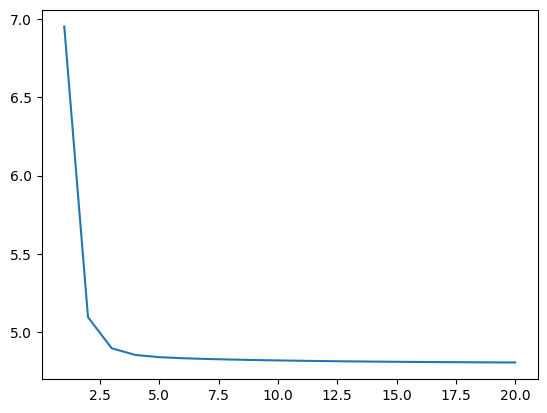

In [80]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(losses)+1), losses)
plt.show()

In [110]:
# prepare the data
batch_size = 1000
dataset = tf.data.Dataset.from_tensor_slices((x, y))

train_split = 0.8
train_ds = dataset.take(int(train_split*m))
test_ds = dataset.skip(int(train_split*m))

print (train_ds)

<_TakeDataset element_spec=(TensorSpec(shape=(9,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>


In [111]:

# create batch
dataset = train_ds.shuffle(buffer_size=x.shape[0]*x.shape[1]).batch(batch_size)

# create a model and fn
class Model(tf.Module):

  def __init__(self,n):
    rand_init = tf.random.uniform(shape=[n], minval=0., maxval=5., seed=22)
    self.w_l = tf.Variable(tf.reshape(rand_init,(-1,1)))
 

  @tf.function
  def __call__(self, x):
    return x @ self.w_l

def loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

model = Model(n+1)

x_train = tf.convert_to_tensor([x for x, _ in train_ds])
y_train = tf.convert_to_tensor([y for _, y in train_ds])


### training
num_epochs = 1000
lr = 0.01

losses = []
for epoch in range(num_epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:

      batch_loss = loss(model(x_batch), y_batch)
    
    gd = tape.gradient(batch_loss, model.variables)

    for g, v in zip(gd,model.variables):
      v.assign_sub(g*lr)

  if epoch % 20 == 0:

    l = loss(model(x_train), y_train)
    print (l)

tf.Tensor(26.508173, shape=(), dtype=float32)
tf.Tensor(4.9356656, shape=(), dtype=float32)
tf.Tensor(4.7242894, shape=(), dtype=float32)
tf.Tensor(4.629359, shape=(), dtype=float32)
tf.Tensor(4.5748706, shape=(), dtype=float32)
tf.Tensor(4.542712, shape=(), dtype=float32)
tf.Tensor(4.5240073, shape=(), dtype=float32)
tf.Tensor(4.512981, shape=(), dtype=float32)
tf.Tensor(4.506484, shape=(), dtype=float32)
tf.Tensor(4.5026326, shape=(), dtype=float32)
tf.Tensor(4.5004683, shape=(), dtype=float32)
tf.Tensor(4.4991803, shape=(), dtype=float32)
tf.Tensor(4.498443, shape=(), dtype=float32)
tf.Tensor(4.4980516, shape=(), dtype=float32)
tf.Tensor(4.4977117, shape=(), dtype=float32)
tf.Tensor(4.4976306, shape=(), dtype=float32)
tf.Tensor(4.497553, shape=(), dtype=float32)
tf.Tensor(4.497521, shape=(), dtype=float32)
tf.Tensor(4.4974375, shape=(), dtype=float32)
tf.Tensor(4.497791, shape=(), dtype=float32)
tf.Tensor(4.4974203, shape=(), dtype=float32)
tf.Tensor(4.497359, shape=(), dtype=float3

In [112]:
x_test = tf.convert_to_tensor([x for x, _ in test_ds])
y_test = tf.convert_to_tensor([y for _, y in test_ds])

l = loss(model(x_test),y_test)
print(l)

tf.Tensor(8.012042, shape=(), dtype=float32)


Use optimizer

In [ ]:

losses = []
optimizer = tf.train.GradientDesc
for epoch in range(num_epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:

      batch_loss = loss(model(x_batch), y_batch)
    
    gd = tape.gradient(batch_loss, model.variables)

    for g, v in zip(gd,model.variables):
      v.assign_sub(g*lr)

  if epoch % 20 == 0:

    l = loss(model(x_train), y_train)
    print (l)